# We will learn pandas library which is very useful for working with tabular data that you  would normally work with in Excel

We also will use `sklearn`'s machine learning algorithms to do some regression  
http://scikit-learn.org/stable/supervised_learning.html

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline


## Read in all of the data from the Nov18,2017 Asilomar trials

In [7]:
glob.glob('/home/bob/datasets/asilomar_data/nov18_2017/csv/*.csv')
df = pd.DataFrame.from_csv('/home/bob/datasets/asilomar_data/nov18_2017/csv/output41.csv')

In [8]:
df.head(1)
df.columns

Index([u'Time', u'Box Detected', u'Box Estimated', u'Distance Lidar',
       u'Distance Estimated', u'Kalman Error', u'Kalman Gain', u'State',
       u'Measurement Cov'],
      dtype='object')

In [9]:

def extract_bb_lidar_from_csv(csv_file):
    df = pd.DataFrame.from_csv(csv_file)
    bboxes_detected = []
    lidar_distances = []
    if 'Box Detected' in df.columns and 'Distance Lidar' in df.columns:
        for box_detected, lidar_distance in zip(df['Box Detected'], df['Distance Lidar']):
            bbox = [int(s) for s in box_detected.replace('[','').replace(']','').replace(',','').split(' ') if len(s)>0]
            bboxes_detected.append(np.array(bbox))
            lidar_distances.append(float(lidar_distance))
        bb_series = pd.Series(data=bboxes_detected)
        lidar_series = pd.Series(data=lidar_distances)
        output_df = pd.DataFrame(columns=['bbox', 'lidar'])
        output_df['bbox'] = bb_series
        output_df['lidar'] = lidar_series
        return output_df

def clean_data(dataframe):
    """
    remove bbox [-1, -1, -1, -1] entries
    remove lidar 0.0 entries
    """
    is_good = []
    for bb, dist in zip(dataframe['bbox'], dataframe['lidar']) :
        if bb is not None and dist is not None:
            if (bb == np.array([-1,-1,-1,-1])).all() or not dist > 0:
                is_good.append(False)
            else:
                is_good.append(True)
        else:
            is_good.append(False)
    return dataframe[is_good].copy()

def normalize_data(dataframe):
    pass

In [10]:
# get all of the .csv filenames
all_csv = glob.glob('/home/bob/datasets/asilomar_data/nov18_2017/csv/*.csv')
csv_files = []
for csv in all_csv:
    # ignore the _t files
    if '_t.csv' not in csv:
        csv_files.append(csv)
dataframes = []
for csv_file in csv_files:
    df_unclean = extract_bb_lidar_from_csv(csv_file=csv_file)
    if df_unclean is None:
        continue
    df_clean = clean_data(dataframe=df_unclean)
    dataframes.append(df_clean)
#     dataframes.append(df_unclean)

In [11]:
# now combine all of the dataframes into one by simple using pd.concat()
df_concat = pd.concat(dataframes)
# format as discrete columns for each bbox value
df_train = pd.DataFrame(columns=['u', 'v', 'w', 'h', 'distance'])
bboxes = df_concat['bbox'].values
bboxes = np.concatenate(bboxes, axis=0).reshape(len(bboxes),4) # reshape bboxes data into a single numpy array
df_train['u'] = bboxes[:,0]
df_train['v'] = bboxes[:,1]
df_train['w'] = bboxes[:,2]
df_train['h'] = bboxes[:,3]
df_train['distance'] = df_concat['lidar'].values

## Now that we've combine all of our data, let's do an Expoloratory Data Analysis (EDA)

## Firstly, let's plot a histogram of the lidar distances

In [12]:
df_train.describe()

,u,v,w,h,distance
count,15841.000000,15841.000000,15841.00000,15841.000000,15841.000000
mean,250.152452,257.231235,355.74768,341.913389,54.681751
std,66.792629,9.236306,65.08083,58.459665,27.591418
min,0.000000,202.000000,110.00000,255.000000,10.964567
25%,228.000000,252.000000,326.00000,300.000000,29.179791
50%,266.000000,256.000000,345.00000,318.000000,55.360894
75%,285.000000,263.000000,378.00000,367.000000,79.852365
max,493.000000,300.000000,640.00000,480.000000,131.820870


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2abc79a90>]], dtype=object)

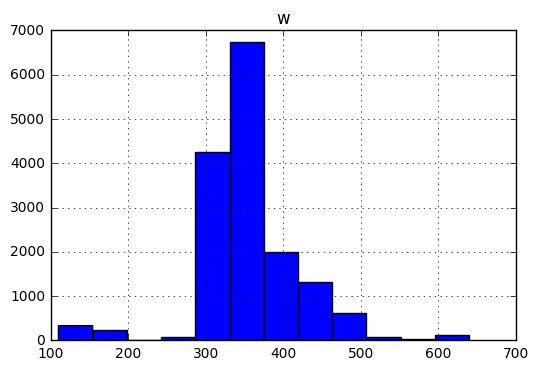

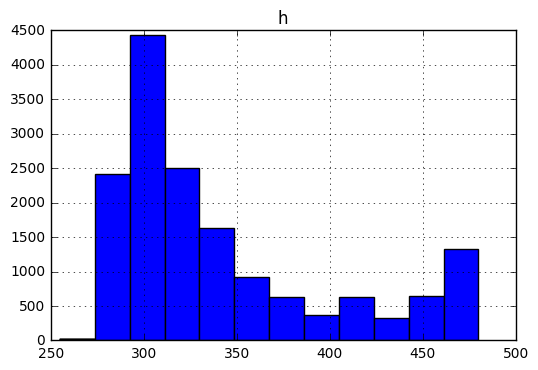

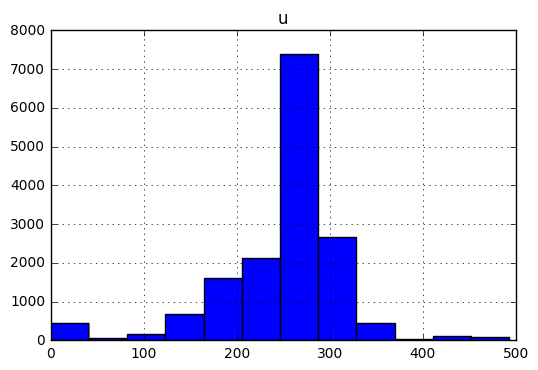

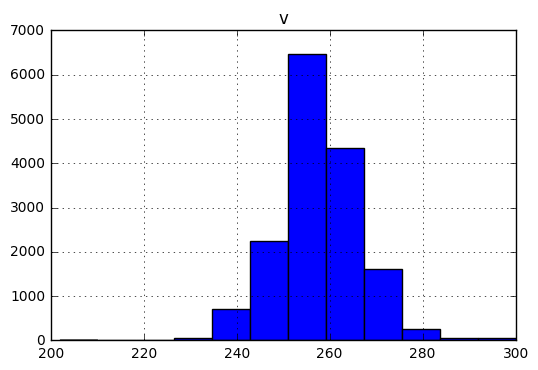

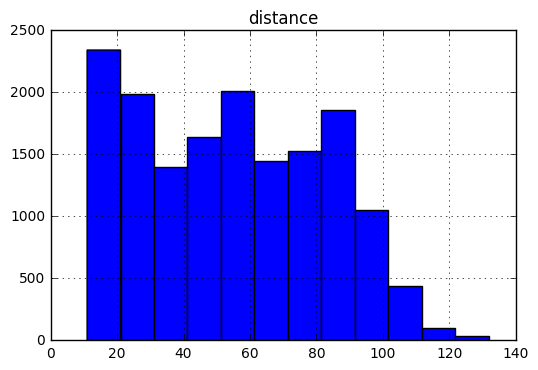

In [13]:
# let's bin our distances into 10ft
num_bins = int((df_train['distance'].max() - df_train['distance'].min()) // 10)
# num_bins = int((df_train['distance'].max() - df_train['distance'].min()) // 1)
df_train.hist(column='w',bins=num_bins)
df_train.hist(column='h',bins=num_bins)
df_train.hist(column='u',bins=num_bins)
df_train.hist(column='v',bins=num_bins)
df_train.hist(column='distance',bins=num_bins)

# more EDA!
Perhaps:
* correllation
* co-dependence (does width depend on height etc.)
* others...

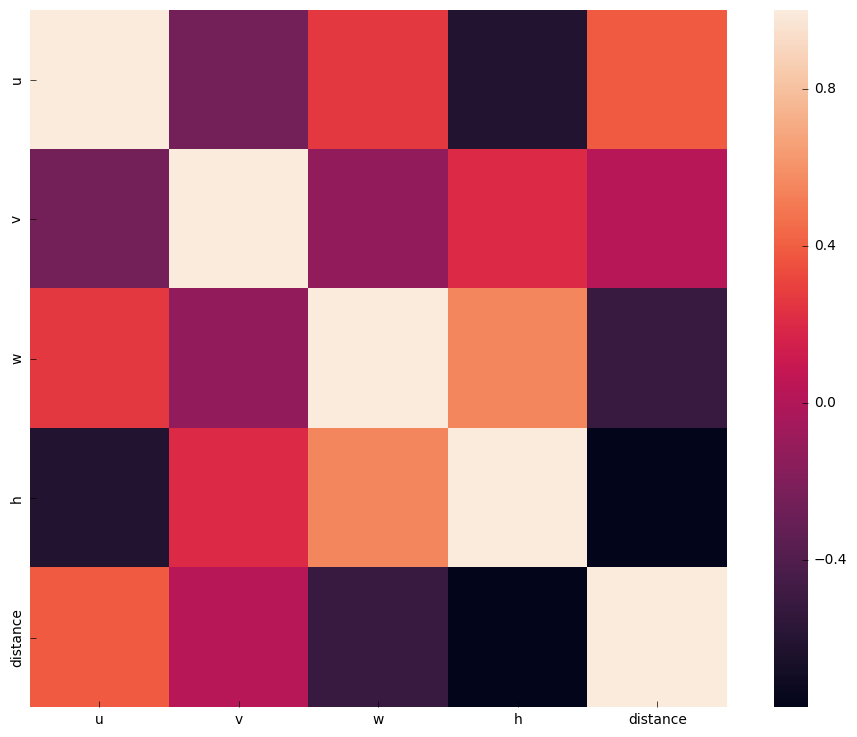

In [14]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

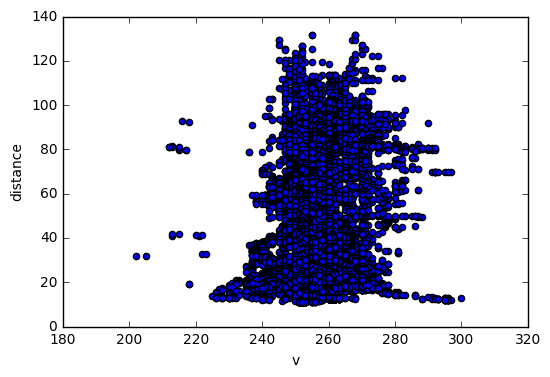

In [15]:
plt.xlabel('v')
plt.ylabel('distance')
plt.scatter(df_train['v'], df_train['distance'])

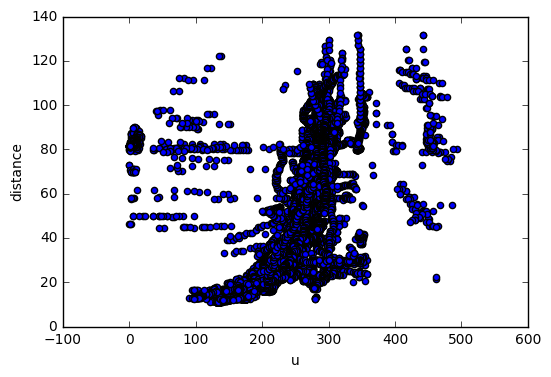

In [16]:
plt.xlabel('u')
plt.ylabel('distance')
plt.scatter(df_train['u'], df_train['distance'])

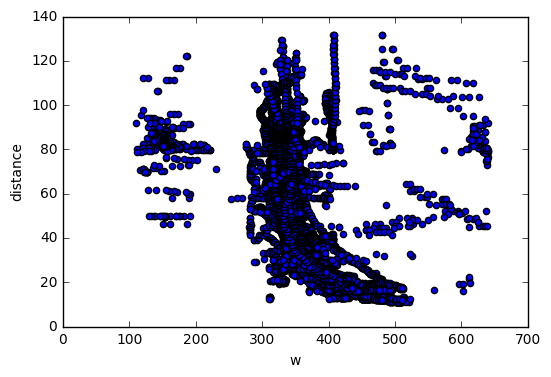

In [17]:
plt.xlabel('w')
plt.ylabel('distance')
plt.scatter(df_train['w'], df_train['distance'])

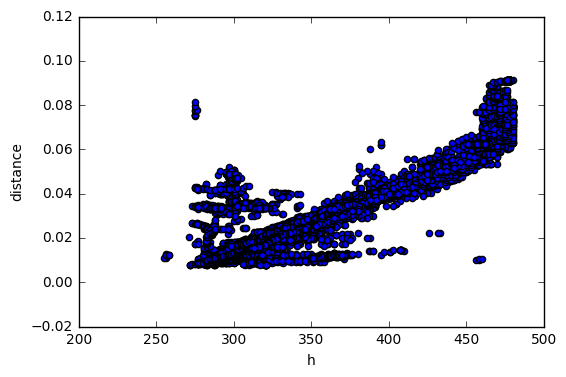

In [18]:
plt.xlabel('h')
plt.ylabel('distance')
plt.scatter(df_train['h'], 1/df_train['distance'])

## Okay we have all of our data in pretty good shape. Let's save

In [19]:
df_train.to_csv('./data/asilomar_nov182017_all.csv')